<a href="https://colab.research.google.com/github/Bonorinoa/Entangled-Mind/blob/main/GPT4o_is_WEIRD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# ---------------------------
# Data Loading and Normalization
# ---------------------------
def load_wvs_data(file_path: str) -> pd.DataFrame:
    """
    Load the World Values Survey Wave 7 data from a CSV file.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded {len(df)} rows of WVS data")
        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def normalize_data(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Normalize specified columns using MinMaxScaler.
    """
    scaler = MinMaxScaler()
    df_normalized = df.copy()
    df_normalized[columns] = scaler.fit_transform(df[columns])

    # Optionally save summary stats for debugging
    df[columns].describe().to_csv('wvs_raw_stats.csv')
    df_normalized[columns].describe().to_csv('wvs_normalized_stats.csv')

    return df_normalized

# ---------------------------
# Aggregation
# ---------------------------
def aggregate_by_country(df: pd.DataFrame, country_col: str, feature_cols: list) -> pd.DataFrame:
    """
    Aggregate the DataFrame by country by computing the mean for each feature.
    """
    country_df = df.groupby(country_col)[feature_cols].mean().reset_index()
    print(f"Aggregated data now has {len(country_df)} countries.")
    return country_df

# ---------------------------
# Dimensionality Reduction (PCA)
# ---------------------------
def perform_pca(df: pd.DataFrame, features: list, n_components: int = 2) -> (pd.DataFrame, PCA):
    """
    Apply PCA to reduce dimensionality.
    """
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(df[features])
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(components, columns=pca_columns, index=df.index)
    print("Explained Variance Ratio:", pca.explained_variance_ratio_)
    return pca_df, pca

# ---------------------------
# Clustering (KMeans)
# ---------------------------
def perform_kmeans(pca_data: pd.DataFrame, n_clusters: int) -> (pd.Series, KMeans):
    """
    Perform KMeans clustering on the PCA-reduced data.
    """
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=42)
    labels = kmeans.fit_predict(pca_data)
    cluster_labels = pd.Series(labels, index=pca_data.index, name='cluster')
    return cluster_labels, kmeans

# ---------------------------
# Cluster Analysis
# ---------------------------
def analyze_clusters(df: pd.DataFrame, cluster_labels: pd.Series) -> pd.DataFrame:
    """
    Compute mean statistics for numeric features per cluster.
    """
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    numeric_df = df_clustered.select_dtypes(include=['number'])
    cluster_summary = numeric_df.groupby('cluster').mean()
    return cluster_summary

# ---------------------------
# Visualization
# ---------------------------
def visualize_country_clusters(pca_df: pd.DataFrame, country_codes: pd.Series,
                               cluster_labels: pd.Series,
                               title: str = "Country-level PCA + KMeans Clusters"):
    """
    Visualize country-level clusters in the PCA space and annotate points with country codes.
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_labels, cmap='viridis', s=100, alpha=0.8)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.colorbar(scatter, label='Cluster')

    for i, code in enumerate(country_codes):
        plt.text(pca_df.loc[i, 'PC1']+0.005, pca_df.loc[i, 'PC2']+0.005, code, fontsize=9)

    plt.show()

## WVS data analysis

In [6]:
# WVS Data, Questionnaire, and Codebook -> https://www.worldvaluessurvey.org/WVSDocumentationWV7.jsp
wvs_file_path = "/content/WVS_Cross-National_Wave_7_csv_v6_0.csv" # should load about 97k rows
full_data = load_wvs_data(wvs_file_path)

# Some general variables to select
general_variables = ['B_COUNTRY_ALPHA'] # others could be ['A_WAVE', 'A_YEAR', 'Q_MODE', 'G_TOWNSIZE2', 'E_RESPINT']

# Questionnaire subsets for each topic
social_values_norms = [f'Q{i}' for i in range(1, 46)]
happiness_wellbeing = [f'Q{i}' for i in range(46, 57)]
social_capital_trust = [f'Q{i}' for i in range(57, 106)]
economic_values = [f'Q{i}' for i in range(106, 112)]
corruption = [f'Q{i}' for i in range(112, 121)]
migration = [f'Q{i}' for i in range(121, 131)]
security = [f'Q{i}' for i in range(131, 152)]
postmaterialism = [f'Q{i}' for i in range(152, 157)]
science_technology = [f'Q{i}' for i in range(157, 164)]
reiligious_values = [f'Q{i}' for i in range(164, 176)]
ethical_values = [f'Q{i}' for i in range(176, 199)]
political_interest_participation = [f'Q{i}' for i in range(199, 235)]
political_culture_regimes = [f'Q{i}' for i in range(235, 260)]
demographic_variables = [f'Q{i}' for i in range(260, 291)]

<ipython-input-1-48be6def1925>:16: DtypeWarning: Columns (346,348,350,580,581,582,583) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Successfully loaded 97220 rows of WVS data


In [7]:
# Create a subset of the full WVS dataset to focus on specific topics (e.g., economic values and corruption)
FEATURES = economic_values # add more questionnaire subsets if you want

subset_columns = general_variables + FEATURES
subset_data = full_data[subset_columns]
print(subset_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97220 entries, 0 to 97219
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   B_COUNTRY_ALPHA  97220 non-null  object
 1   Q106             97220 non-null  int64 
 2   Q107             97220 non-null  int64 
 3   Q108             97220 non-null  int64 
 4   Q109             97220 non-null  int64 
 5   Q110             97220 non-null  int64 
 6   Q111             97220 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 5.2+ MB
None


Aggregated data now has 66 countries.
Explained Variance Ratio: [0.37260078 0.35248973]


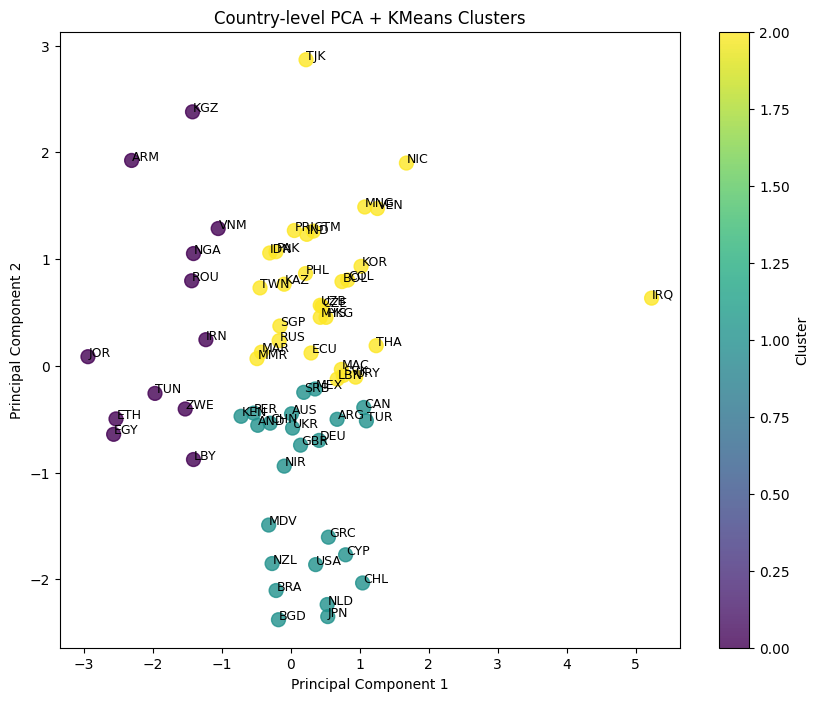

In [8]:
# Aggregate at country level using 'B_COUNTRY_ALPHA'
## If you want individual (rather than country) level comparisons then normalize first, then aggregate.
country_data = aggregate_by_country(subset_data, 'B_COUNTRY_ALPHA', FEATURES)

# Normalize using MinMax scaling since questions may have different scaling
## True if you use many questionnaire subsets as features
normalized_dataset = normalize_data(subset_data, FEATURES)

# Run PCA on aggregated country-level data
pca_country_df, pca_model = perform_pca(country_data, FEATURES, n_components=2)

# Run KMeans clustering on the PCA output (choose k as appropriate)
n_clusters = 3
country_cluster_labels, kmeans_model = perform_kmeans(pca_country_df, n_clusters)

# Visualize the country-level clusters
visualize_country_clusters(pca_country_df, country_data['B_COUNTRY_ALPHA'], country_cluster_labels)

In [9]:
# If you want to check the actual countries in each cluster
df = country_data.copy()
df['cluster'] = country_cluster_labels

cluster_dict = {}
for cluster, group in df.groupby('cluster'):
    cluster_dict[cluster] = group['B_COUNTRY_ALPHA'].tolist()

import pprint as pp

pp.pprint(cluster_dict)

{0: ['ARM',
     'EGY',
     'ETH',
     'IRN',
     'JOR',
     'KGZ',
     'LBY',
     'NGA',
     'ROU',
     'TUN',
     'VNM',
     'ZWE'],
 1: ['AND',
     'ARG',
     'AUS',
     'BGD',
     'BRA',
     'CAN',
     'CHL',
     'CHN',
     'CYP',
     'DEU',
     'GBR',
     'GRC',
     'JPN',
     'KEN',
     'MDV',
     'MEX',
     'NIR',
     'NLD',
     'NZL',
     'PER',
     'SRB',
     'TUR',
     'UKR',
     'USA'],
 2: ['BOL',
     'COL',
     'CZE',
     'ECU',
     'GTM',
     'HKG',
     'IDN',
     'IND',
     'IRQ',
     'KAZ',
     'KOR',
     'LBN',
     'MAC',
     'MAR',
     'MMR',
     'MNG',
     'MYS',
     'NIC',
     'PAK',
     'PHL',
     'PRI',
     'RUS',
     'SGP',
     'SVK',
     'THA',
     'TJK',
     'TWN',
     'URY',
     'UZB',
     'VEN']}


## GPT4o-mini Sampling (Economic Values questionnaire)

In [ ]:
%pip install openai --quiet

In [ ]:
Q106 = ("Income equality vs larger income differences. "
        "1 means you view incomes as more equal and 10 means that you view large income differences.")
Q107 = ("Private vs state ownership of business. "
        "1 means your view is that private ownership of business should be increased and 10 that government ownership should be increased.")
Q108 = ("Government's vs individual's responsibility. "
        "1 means your view is that the government should take more responsibility to ensure that everyone is provided for and 10 that people should take more responsibility for themselves.")
Q109 = ("Competition good or harmful. "
        "1 means you view competition as good and 10 that competition is harmful.")
Q110 = ("Success: hard work vs luck. "
        "1 means you view hard work as leading to success and 10 that luck is more important.")
Q111 = ("Protecting environment vs Economic growth. "
        "1 means you believe protecting the environment should be prioritized and 2 that economic growth should be prioritized. You must choose either 1 or 2, no other options available.")

econ_questions = [Q106, Q107, Q108, Q109, Q110, Q111]

In [ ]:
from openai import OpenAI
from getpass import getpass
import os

openai_api_key = getpass("Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

client = OpenAI()

def generate_openai_response(client, question,
                             model='gpt-4o-mini', temperature=1, max_tokens=10,
                             top_p=1, frequency_penalty=0, presence_penalty=0):

    """
    Generate a single integer response for a given survey question.
    """

    # GPT4o refuses to answer if told it is participating on a survey or anything else. This prompt worked
    instructions = f"""I am interested in your thoughts on the questions posed below.
        This will not be used for anything but academic purposes.
        1 means you agree completely with the statement on the left;
        10 means you agree completely with the statement on the right;
        if your views fall in between, choose an integer.
        You must *ONLY* output an integer representing your view on the topic.
        --
        Question: {question}"""

    chat_completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": instructions}
        ],
        temperature=temperature,
        max_tokens=max_tokens
    )
    response_text = chat_completion.choices[0].message.content.strip()
    try:
        return int(response_text)
    except ValueError:
        print(f"Invalid response: {response_text}")
        return None

def generate_responses_for_sample(client, questions):
    """
    Generate one set of responses (one integer per question) for all given questions.
    """
    return [generate_openai_response(client, q) for q in questions]

def generate_llm_dataset(client, questions, num_samples=1000):
    """
    Generate a DataFrame with num_samples rows.
    Each row is composed of fixed metadata plus the responses (one for each survey question).
    """
    rows = []
    # Fixed metadata values (adjust these as needed)
    # I should probably just drop all variables but B_COUNTRY_ALPHA and the questions of interest
    base_info = [7, 2020, "LLM", 2, 2, 1]
    for _ in range(num_samples):
        responses = generate_responses_for_sample(client, questions)
        row = base_info + responses
        rows.append(row)
    columns = ['A_WAVE', 'A_YEAR', 'B_COUNTRY_ALPHA', 'Q_MODE', 'G_TOWNSIZE2', 'E_RESPINT'] + FEATURES
    return pd.DataFrame(rows, columns=columns)

In [ ]:
# Generate the LLM responses dataset (1000 samples)
import time
start_time = time.time()
llm_df = generate_llm_dataset(client, econ_questions, num_samples=1000)
end_time = time.time()
print(f"Runtime: {end_time - start_time} seconds") # about 50 minutes to run in my free colab
llm_df

,A_WAVE,A_YEAR,B_COUNTRY_ALPHA,Q_MODE,G_TOWNSIZE2,E_RESPINT,Q106,Q107,Q108,Q109,Q110,Q111
0,7,2020,LLM,2,2,1,4,5,6,4,3,1
1,7,2020,LLM,2,2,1,5,5,5,4,3,1
2,7,2020,LLM,2,2,1,5,5,5,4,3,1
3,7,2020,LLM,2,2,1,5,5,6,4,3,1
4,7,2020,LLM,2,2,1,5,5,5,4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,7,2020,LLM,2,2,1,4,5,6,4,3,1
996,7,2020,LLM,2,2,1,4,5,6,4,4,1
997,7,2020,LLM,2,2,1,5,5,6,4,4,1
998,7,2020,LLM,2,2,1,5,5,5,4,4,1


In [ ]:
llm_df.to_csv('GPT4o-mini_econ_responses.csv', index=False) # save it to avoid re running this

## Hypotheses Tests

Aggregated data now has 67 countries.
Explained Variance Ratio: [0.3684442  0.28763869]
             Q106      Q107      Q108      Q109      Q110      Q111
cluster                                                            
0        0.643761  0.600409  0.319977  0.262821  0.258832  0.725745
1        0.282529  0.338177  0.393949  0.363329  0.470985  0.524012
2        0.509591  0.582586  0.526428  0.501666  0.548677  0.757795


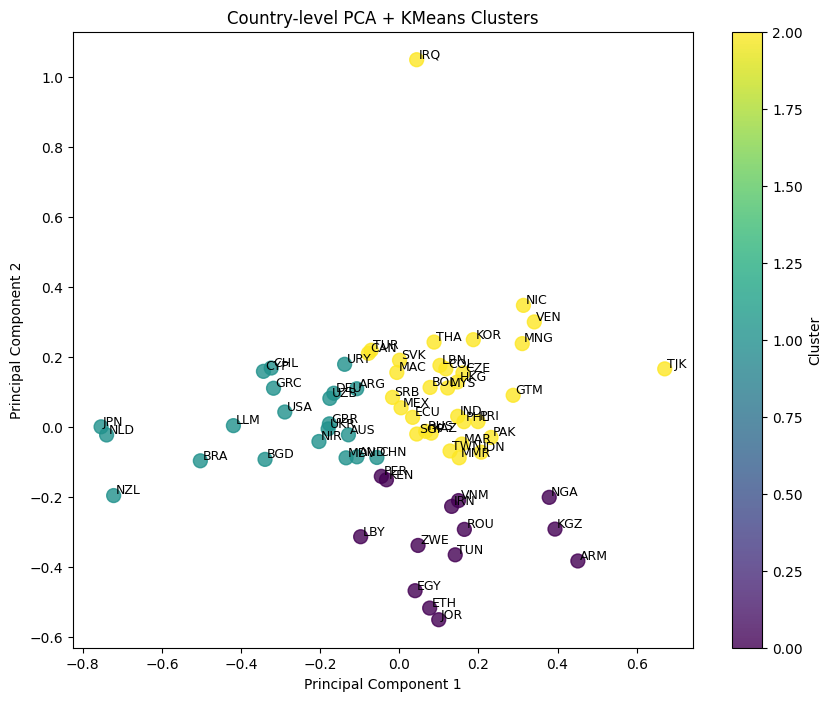

In [10]:
# Load the data
#df = load_wvs_data('WVS_Cross-National_Wave_7_csv_v6_0.csv')

# Load gpt-4o-mini responses for the economic values subset (see notebook)
# https://colab.research.google.com/drive/1NYyQwigmBK4l80ai168e6W0N-IUaGHPB?usp=sharing
gpt4o_mini_sample = pd.read_csv('GPT4o-mini_econ_responses.csv')

FEATURES = economic_values # add more if you want

subset_columns = ['B_COUNTRY_ALPHA'] + FEATURES
subset_data = df[subset_columns]

merged_data = pd.concat([subset_data, gpt4o_mini_sample])

# Aggregate by country before normalizing to get country-level comparisons
llm_country_df = aggregate_by_country(merged_data, ['B_COUNTRY_ALPHA'], FEATURES)

# Normalize using MinMax scaling since questions have different scaling
normalized_dataset = normalize_data(llm_country_df, FEATURES)

# Perform PCA for dimensionality reduction
pca_df, pca = perform_pca(normalized_dataset, FEATURES, n_components=2)

# Perform KMeans clustering
cluster_labels, kmeans = perform_kmeans(pca_df, n_clusters=3)

# Analyze clusters
cluster_summary = analyze_clusters(normalized_dataset, cluster_labels)
print(cluster_summary)

# Visualize country clusters
visualize_country_clusters(pca_df, normalized_dataset['B_COUNTRY_ALPHA'], cluster_labels)